In [48]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import toml
import joblib
import torch
from m6anet.model.model import MILModel
from m6anet.utils.builder import build_dataloader

In [59]:
# model_config = "../m6anet/model/configs/model_configs/1_neighbor/prod_pooling.toml"
# train_config = "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/1_neighbor/oversampled_regularized.toml"
# model_dir = "/data03/christopher/m6anet_new_dataprep_results/prod_pooling_1_neighbor_regularized/"

# test_results = joblib.load(os.path.join(model_dir, "test_results.joblib"))['pr_auc']
# best_model = np.argmin(test_results) + 1
# model_weight = os.path.join(model_dir, "model_states", str(best_model), "model_states.pt")

# device = "cuda:3"

# model_config = toml.load(model_config)
# train_config = toml.load(train_config)

# train_config['dataloader']['train'].pop('sampler')

# model = MILModel(model_config).to(device)
# model.load_state_dict(torch.load(model_weight))

# num_workers = 25

# train_dl, test_dl, val_dl = build_dataloader(train_config, num_workers)

There are 81628 train sites
There are 20091 test sites
There are 25713 val sites


In [69]:
model_config = "../m6anet/model/configs/model_configs/1_neighbor/prod_pooling_attention.toml"
train_config = "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/1_neighbor/oversampled_regularized.toml"
model_weight = "../m6anet/model/model_states/attention_pooling_pr_auc.pt"
device = "cuda:3"

model_config = toml.load(model_config)
train_config = toml.load(train_config)

train_config['dataloader']['train'].pop('sampler')
# 
model = MILModel(model_config).to(device)
model.load_state_dict(torch.load(model_weight))

num_workers = 25

train_dl, test_dl, val_dl = build_dataloader(train_config, num_workers)

There are 81628 train sites
There are 20091 test sites
There are 25713 val sites


In [61]:
from sklearn.calibration import CalibratedClassifierCV, IsotonicRegression
from sklearn.linear_model import LogisticRegressionCV
import torch
from torch import nn, optim

In [62]:
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

def generate_proba(model, pair_dataloader, device, mode='site'):
    model.eval()
    all_y_true = []
    all_y_pred = []
    with torch.no_grad():
        for batch in pair_dataloader:
            y_true = batch.pop('y').to(device).flatten()
            X = {key: val.to(device) for key, val in batch.items()}
            if mode == 'site':
                y_pred = model(X)
                if len(y_pred.shape) > 1:
                    y_pred = y_pred[:, 1]
            elif mode =='read':
                y_pred = model.get_read_probability(X)
                y_pred = 1 - torch.prod(1 - y_pred, axis=1)
            else:
                raise ValueError("Invalid mode")
                
            y_true = y_true.detach().cpu().numpy()
            y_pred = y_pred.detach().cpu().numpy()
            
            all_y_true.extend(y_true)
            
            all_y_pred.extend(y_pred)

    return np.array(all_y_true), np.array(all_y_pred)

In [63]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

In [64]:
import torch
from torch import nn, optim
from torch.nn import functional as F


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
    
    
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model, mode):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
        if mode not in ('site', 'read'):
            raise ValueError("mode must be either site or read and not {}".format(mode))
        self.mode = mode
        self.model = model
    
    def get_logits(self, X):
        if self.mode == 'site':
            y_pred = self.model(X)
            if len(y_pred.shape) > 1:
                y_pred = y_pred[:, 1]
        else:
            y_pred = self.get_read_probability(X)
            y_pred = 1 - torch.prod(1 - y_pred, axis=1)
            y_pred = y_pred

        device = y_pred.device
        min_prob, max_prob = torch.Tensor([1e-08]).to(device), torch.Tensor([0.99]).to(device)
        
        y_pred = torch.max(y_pred, min_prob)
        y_pred = torch.min(y_pred, max_prob)

        logits = torch.cat([torch.log((1 - y_pred) / y_pred).view(-1, 1),
                            torch.log(y_pred / (1 - y_pred)).view(-1, 1)], axis=1)
        return logits
    
    def get_read_probability(self, X):
        return model.get_read_probability(X)
    
    def forward(self, X):
        logits = self.get_logits(X)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return F.softmax(logits / temperature, dim=1)

def set_temperature(model, valid_loader, device, max_iter=1000):
    """
    Tune the tempearature of the model (using the validation set).
    We're going to set it to optimize NLL.
    valid_loader (DataLoader): validation set loader
    """
    
    model = model.to(device)
    nll_criterion = nn.CrossEntropyLoss()
    ece_criterion = _ECELoss()

    # First: collect all the logits and labels for the validation set
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for batch in valid_loader:
            y_true = batch.pop('y').to(device).flatten()
            X = {key: val.to(device) for key, val in batch.items()}                

            logits = model.get_logits(X)
            logits_list.append(logits)
            labels_list.append(y_true)
        logits = torch.cat(logits_list).to(device)
        labels = torch.cat(labels_list).to(device)
    # Calculate NLL and ECE before temperature scaling
    before_temperature_nll = nll_criterion(logits, labels).item()
    before_temperature_ece = ece_criterion(logits, labels).item()
    print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

    # Next: optimize the temperature w.r.t. NLL
    optimizer = optim.LBFGS([model.temperature], lr=0.01, max_iter=max_iter)

    def eval():
        loss = nll_criterion(model.temperature_scale(logits), labels)
        loss.backward()
        return loss
    optimizer.step(eval)

    # Calculate NLL and ECE after temperature scaling
    after_temperature_nll = nll_criterion(model.temperature_scale(logits), labels).item()
    after_temperature_ece = ece_criterion(model.temperature_scale(logits), labels).item()
    print('Optimal temperature: %.3f' % model.temperature.item())
    print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

    return model


In [65]:
def plot_reliability_curve(y_true, prob_pos, name, ax, n_bins=10):

    clf_score = brier_score_loss(y_true, prob_pos, pos_label=1)
    y_pred = (np.array(prob_pos) >= 0.5) * 1

    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_true, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_true, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_true, y_pred))
    
    fraction_of_positives, mean_predicted_value = calibration_curve(all_y_true, prob_pos, n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

(array([3648., 4860., 4115., 3494., 2893., 2315., 1776., 1243.,  792.,
         577.]),
 array([0.00160378, 0.10120505, 0.20080632, 0.3004076 , 0.40000886,
        0.49961013, 0.5992114 , 0.69881266, 0.79841393, 0.8980152 ,
        0.99761647], dtype=float32),
 <BarContainer object of 10 artists>)

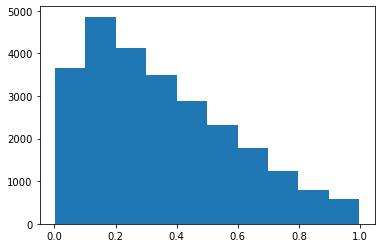

In [68]:
plt.hist(prob_pos)

(array([22099.,   306.,   172.,   124.,   127.,   119.,   109.,   145.,
          200.,  2312.]),
 array([4.8589336e-21, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

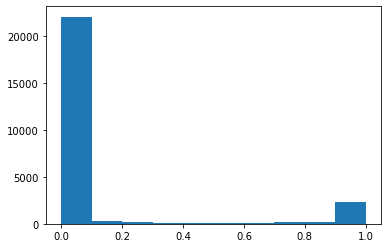

In [70]:
all_y_true, prob_pos = generate_proba(model, val_dl, device, mode='site')
plt.hist(prob_pos)

(array([13782.,  3540.,  2055.,  1476.,  1043.,   852.,   735.,   628.,
          603.,   999.]),
 array([5.3644180e-07, 9.9995546e-02, 1.9999056e-01, 2.9998556e-01,
        3.9998057e-01, 4.9997559e-01, 5.9997058e-01, 6.9996560e-01,
        7.9996061e-01, 8.9995563e-01, 9.9995065e-01], dtype=float32),
 <BarContainer object of 10 artists>)

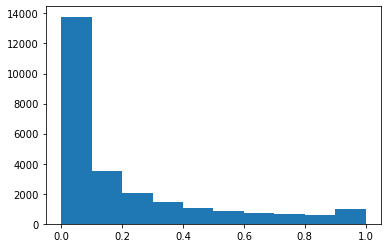

In [71]:
all_y_true, prob_pos = generate_proba(model, val_dl, device, mode='read')
plt.hist(prob_pos)

m6ANet_attention_pooling:
	Brier: 0.163
	Precision: 0.135
	Recall: 0.766
	F1: 0.229

m6ANet_isotonic_regression:
	Brier: 0.211
	Precision: 0.122
	Recall: 0.789
	F1: 0.212

m6ANet_sklearn_sigmoid_calibration:
	Brier: 0.069
	Precision: 0.285
	Recall: 0.508
	F1: 0.365

Before temperature - NLL: 0.543, ECE: 0.075
Optimal temperature: -2.836
After temperature - NLL: 0.850, ECE: 0.360
m6ANet_temperature_scaling:
	Brier: 0.430
	Precision: 0.015
	Recall: 0.241
	F1: 0.028



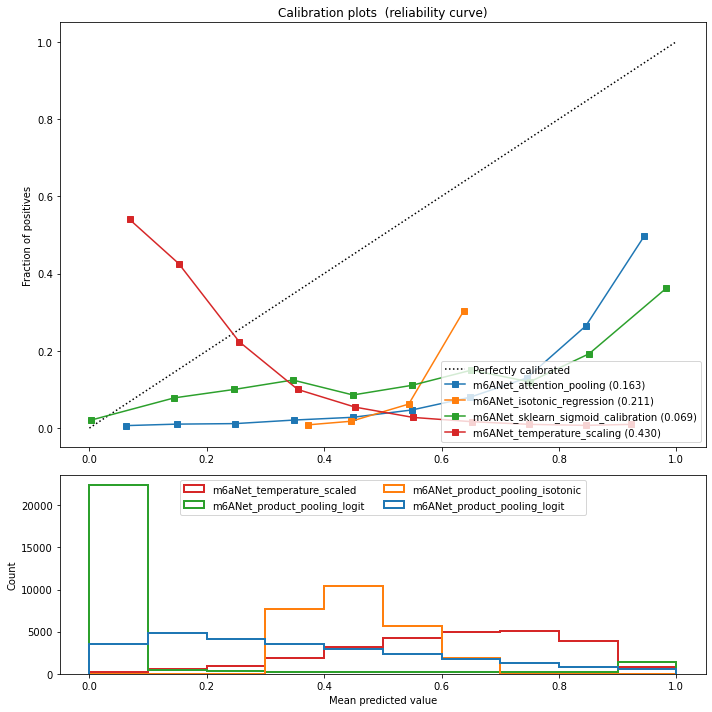

In [66]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

n_bins = 10
mode = 'site'

all_y_true, prob_pos = generate_proba(model, val_dl, device, mode=mode)
all_y_true_test, prob_pos_test = generate_proba(model, train_dl, device, mode=mode)

# Reliability curve for base model:
plot_reliability_curve(all_y_true, prob_pos, "m6ANet_attention_pooling", ax1, n_bins)

# Reliability curve for isotonically calibrated classifier using test set
isotonic_clf = IsotonicRegression().fit(all_y_true_test, prob_pos_test)
calibrated_prob_isotonic = isotonic_clf.transform(prob_pos)
plot_reliability_curve(all_y_true, calibrated_prob_isotonic, "m6ANet_isotonic_regression", ax1, n_bins)

# Reliability curve for sklearn sigmoid calibrated classifier using test set

prob_pos_test = np.array(prob_pos_test).reshape(-1, 1)
prob_pos_test = np.where(prob_pos_test < 1e-5, 1e-5, prob_pos_test)
prob_pos_test = np.where(prob_pos_test == 1, 0.99, prob_pos_test)
dummy_logit_test = np.log(prob_pos_test / (1 - prob_pos_test))

prob_pos = np.array(prob_pos).reshape(-1, 1)
prob_pos = np.where(prob_pos < 1e-5, 1e-5, prob_pos)
prob_pos = np.where(prob_pos == 1, 0.99, prob_pos)
dummy_logit = np.log(prob_pos / (1 - prob_pos))
sigmoid_clf = CalibratedClassifierCV(LogisticRegressionCV(max_iter=10000),
                                     method='sigmoid').fit(prob_pos_test, all_y_true_test)
calibrated_prob_sigmoid = sigmoid_clf.predict_proba(dummy_logit)[:, 1]

plot_reliability_curve(all_y_true, calibrated_prob_sigmoid, "m6ANet_sklearn_sigmoid_calibration", ax1, n_bins)

# Plotting reliability curve for temperature scaling calibrated classifier using test set

temp_scaled_model = ModelWithTemperature(model, mode)
temp_scaled_model = set_temperature(temp_scaled_model, train_dl, device, max_iter=100)

_, temp_scaled_proba = generate_proba(temp_scaled_model, val_dl, device, mode=mode)

plot_reliability_curve(all_y_true, temp_scaled_proba, "m6ANet_temperature_scaling", ax1, n_bins)


ax2.hist([prob_pos.reshape(-1, ), calibrated_prob_isotonic.reshape(-1, ), calibrated_prob_sigmoid.reshape(-1, ),
          temp_scaled_proba.reshape(-1, )],
          range=(0, 1), bins=10, label=['m6ANet_product_pooling_logit', 'm6ANet_product_pooling_isotonic', 
                                        'm6ANet_product_pooling_logit', 'm6aNet_temperature_scaled'],
         histtype="step", lw=2)


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

plt.show()


m6ANet_attention_pooling:
	Brier: 0.092
	Precision: 0.238
	Recall: 0.790
	F1: 0.365

m6ANet_isotonic_regression:
	Brier: 0.109
	Precision: 0.245
	Recall: 0.784
	F1: 0.373

m6ANet_sklearn_sigmoid_calibration:
	Brier: 0.062
	Precision: 0.361
	Recall: 0.640
	F1: 0.462

Before temperature - NLL: 0.340, ECE: 0.048
Optimal temperature: 0.525
After temperature - NLL: 0.420, ECE: 0.176
m6ANet_temperature_scaling:
	Brier: 0.091
	Precision: 0.241
	Recall: 0.788
	F1: 0.369



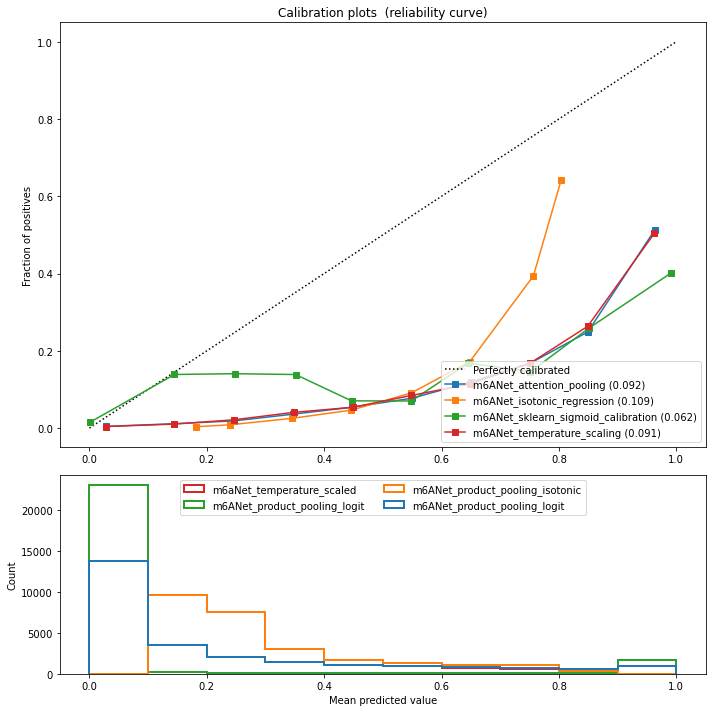

In [58]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

n_bins = 10
mode = 'read'

all_y_true, prob_pos = generate_proba(model, val_dl, device, mode=mode)
all_y_true_test, prob_pos_test = generate_proba(model, train_dl, device, mode=mode)

# Reliability curve for base model:
plot_reliability_curve(all_y_true, prob_pos, "m6ANet_attention_pooling", ax1, n_bins)

# Reliability curve for isotonically calibrated classifier using test set
isotonic_clf = IsotonicRegression().fit(all_y_true_test, prob_pos_test)
calibrated_prob_isotonic = isotonic_clf.transform(prob_pos)
plot_reliability_curve(all_y_true, calibrated_prob_isotonic, "m6ANet_isotonic_regression", ax1, n_bins)

# Reliability curve for sklearn sigmoid calibrated classifier using test set

prob_pos_test = np.array(prob_pos_test).reshape(-1, 1)
prob_pos_test = np.where(prob_pos_test < 1e-5, 1e-5, prob_pos_test)
prob_pos_test = np.where(prob_pos_test == 1, 0.99, prob_pos_test)
dummy_logit_test = np.log(prob_pos_test / (1 - prob_pos_test))

prob_pos = np.array(prob_pos).reshape(-1, 1)
prob_pos = np.where(prob_pos < 1e-5, 1e-5, prob_pos)
prob_pos = np.where(prob_pos == 1, 0.99, prob_pos)
dummy_logit = np.log(prob_pos / (1 - prob_pos))
sigmoid_clf = CalibratedClassifierCV(LogisticRegressionCV(max_iter=10000),
                                     method='sigmoid').fit(prob_pos_test, all_y_true_test)
calibrated_prob_sigmoid = sigmoid_clf.predict_proba(dummy_logit)[:, 1]

plot_reliability_curve(all_y_true, calibrated_prob_sigmoid, "m6ANet_sklearn_sigmoid_calibration", ax1, n_bins)

# Plotting reliability curve for temperature scaling calibrated classifier using test set

temp_scaled_model = ModelWithTemperature(model, mode)
temp_scaled_model = set_temperature(temp_scaled_model, train_dl, device, max_iter=100)

_, temp_scaled_proba = generate_proba(temp_scaled_model, val_dl, device, mode=mode)

plot_reliability_curve(all_y_true, temp_scaled_proba, "m6ANet_temperature_scaling", ax1, n_bins)


ax2.hist([prob_pos.reshape(-1, ), calibrated_prob_isotonic.reshape(-1, ), calibrated_prob_sigmoid.reshape(-1, ),
          temp_scaled_proba.reshape(-1, )],
          range=(0, 1), bins=10, label=['m6ANet_product_pooling_logit', 'm6ANet_product_pooling_isotonic', 
                                        'm6ANet_product_pooling_logit', 'm6aNet_temperature_scaled'],
         histtype="step", lw=2)


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

plt.show()


In [10]:
from statsmodels.stats.multitest import multipletests
from m6anet.utils.data_utils import NanopolishDS
from torch.utils.data import DataLoader


In [11]:
model_config = "../m6anet/model/configs/model_configs/1_neighbor/prod_pooling_attention.toml"
train_config = "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/1_neighbor/oversampled_regularized.toml"
alpha = 0.005
model_config = toml.load(model_config)
train_config = toml.load(train_config)
train_config['dataset']['root_dir'] = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
model = MILModel(model_config).to(device)
model.load_state_dict(torch.load(model_weight))
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
num_workers = 25

train_ds = NanopolishDS(**train_config["dataset"], mode='Train')
test_ds = NanopolishDS(**train_config["dataset"], mode='Test')
val_ds = NanopolishDS(**train_config["dataset"], mode='Val')

for ds in (train_ds, test_ds, val_ds):
    ds.data_info = pd.merge(ds.data_info, ko_table, on=["gene_id", "genomic_position"])
    ds.data_info["pvalue"] = multipletests(ds.data_info.pvalue, alpha=alpha, method='fdr_bh')[1]
    ko_sensitivity = (ds.data_info["pvalue"] < alpha) * 1
        
    ds.data_info["modification_status"] = (ds.data_info["modification_status"].values) | (ko_sensitivity.values)
    ds.data_info = ds.data_info.reset_index(drop=True)

from m6anet.utils.builder import random_fn
from m6anet.utils.data_utils import train_collate

train_dl = DataLoader(train_ds, worker_init_fn=random_fn, num_workers=num_workers, 
                      collate_fn=train_collate, batch_size=256)
test_dl = DataLoader(test_ds, worker_init_fn=random_fn, num_workers=num_workers, 
                     collate_fn=train_collate, batch_size=256)
val_dl = DataLoader(val_ds, worker_init_fn=random_fn, num_workers=num_workers, 
                    collate_fn=train_collate, batch_size=256)

m6ANet_attention_pooling:
	Brier: 0.109
	Precision: 0.472
	Recall: 0.494
	F1: 0.483

m6ANet_isotonic_regression:
	Brier: 0.082
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m6ANet_sklearn_sigmoid_calibration:
	Brier: 0.109
	Precision: 0.502
	Recall: 0.476
	F1: 0.489

Before temperature - NLL: 1.895, ECE: 0.119
Optimal temperature: 5388845056.000
After temperature - NLL: 0.693, ECE: 0.376
m6ANet_temperature_scaling:
	Brier: 0.250
	Precision: 0.114
	Recall: 1.000
	F1: 0.204



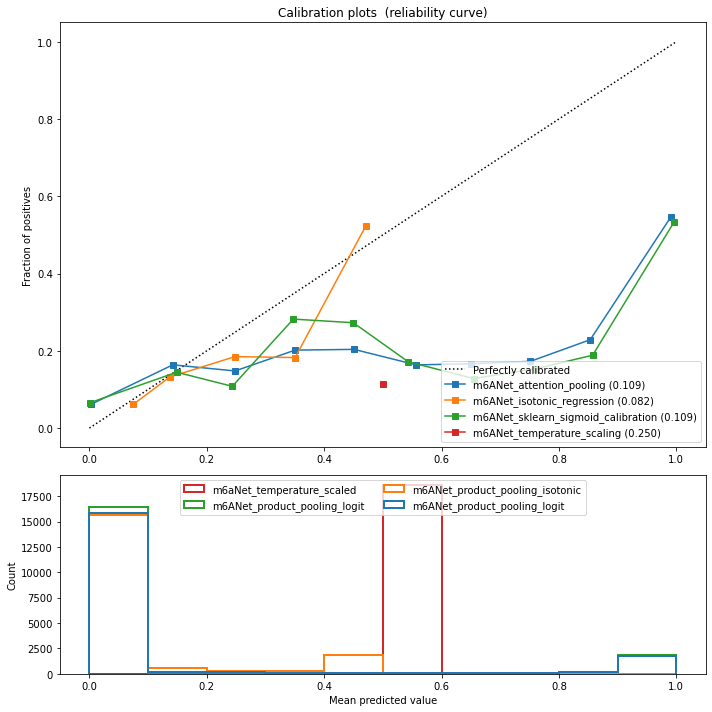

In [12]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

n_bins = 10
mode = 'site'

all_y_true, prob_pos = generate_proba(model, val_dl, device, mode=mode)
all_y_true_test, prob_pos_test = generate_proba(model, train_dl, device, mode=mode)

# Reliability curve for base model:
plot_reliability_curve(all_y_true, prob_pos, "m6ANet_attention_pooling", ax1, n_bins)

# Reliability curve for isotonically calibrated classifier using test set
isotonic_clf = IsotonicRegression().fit(all_y_true_test, prob_pos_test)
calibrated_prob_isotonic = isotonic_clf.transform(prob_pos)
plot_reliability_curve(all_y_true, calibrated_prob_isotonic, "m6ANet_isotonic_regression", ax1, n_bins)

# Reliability curve for sklearn sigmoid calibrated classifier using test set

prob_pos_test = np.array(prob_pos_test).reshape(-1, 1)
prob_pos_test = np.where(prob_pos_test < 1e-5, 1e-5, prob_pos_test)
prob_pos_test = np.where(prob_pos_test == 1, 0.99, prob_pos_test)
dummy_logit_test = np.log(prob_pos_test / (1 - prob_pos_test))

prob_pos = np.array(prob_pos).reshape(-1, 1)
prob_pos = np.where(prob_pos < 1e-5, 1e-5, prob_pos)
prob_pos = np.where(prob_pos == 1, 0.99, prob_pos)
dummy_logit = np.log(prob_pos / (1 - prob_pos))
sigmoid_clf = CalibratedClassifierCV(LogisticRegressionCV(max_iter=10000),
                                     method='sigmoid').fit(prob_pos_test, all_y_true_test)
calibrated_prob_sigmoid = sigmoid_clf.predict_proba(dummy_logit)[:, 1]

plot_reliability_curve(all_y_true, calibrated_prob_sigmoid, "m6ANet_sklearn_sigmoid_calibration", ax1, n_bins)

# Plotting reliability curve for temperature scaling calibrated classifier using test set

temp_scaled_model = ModelWithTemperature(model, mode)
temp_scaled_model = set_temperature(temp_scaled_model, train_dl, device, max_iter=1000)

_, temp_scaled_proba = generate_proba(temp_scaled_model, val_dl, device, mode=mode)

plot_reliability_curve(all_y_true, temp_scaled_proba, "m6ANet_temperature_scaling", ax1, n_bins)


ax2.hist([prob_pos.reshape(-1, ), calibrated_prob_isotonic.reshape(-1, ), calibrated_prob_sigmoid.reshape(-1, ),
          temp_scaled_proba.reshape(-1, )],
          range=(0, 1), bins=10, label=['m6ANet_product_pooling_logit', 'm6ANet_product_pooling_isotonic', 
                                        'm6ANet_product_pooling_logit', 'm6aNet_temperature_scaled'],
         histtype="step", lw=2)


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

plt.show()


m6ANet_attention_pooling:
	Brier: 0.117
	Precision: 0.373
	Recall: 0.540
	F1: 0.441

m6ANet_isotonic_regression:
	Brier: 0.108
	Precision: 0.792
	Recall: 0.239
	F1: 0.367

m6ANet_sklearn_sigmoid_calibration:
	Brier: 0.096
	Precision: 0.529
	Recall: 0.425
	F1: 0.471

Before temperature - NLL: 0.572, ECE: 0.088
Optimal temperature: 0.692
After temperature - NLL: 0.468, ECE: 0.135
m6ANet_temperature_scaling:
	Brier: 0.116
	Precision: 0.374
	Recall: 0.551
	F1: 0.445



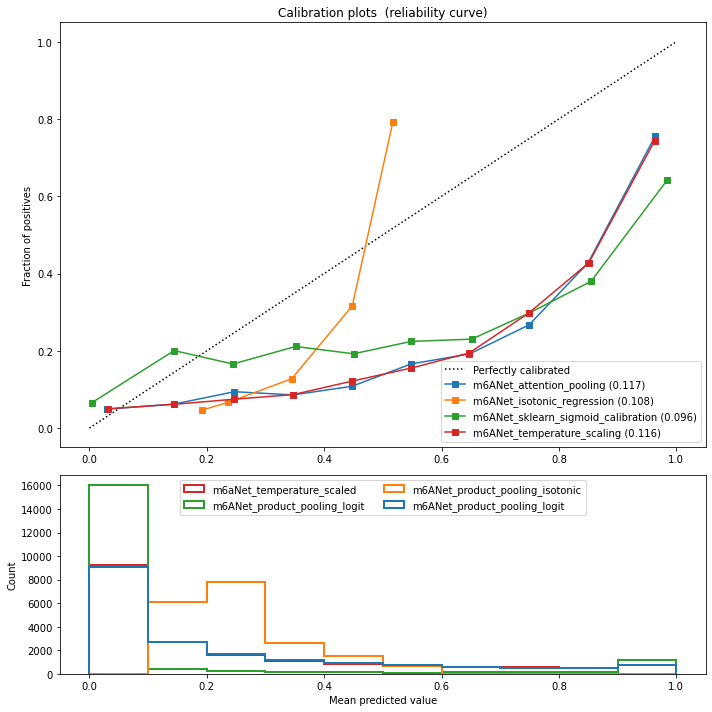

In [13]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

n_bins = 10
mode = 'read'

all_y_true, prob_pos = generate_proba(model, val_dl, device, mode=mode)
all_y_true_test, prob_pos_test = generate_proba(model, train_dl, device, mode=mode)

# Reliability curve for base model:
plot_reliability_curve(all_y_true, prob_pos, "m6ANet_attention_pooling", ax1, n_bins)

# Reliability curve for isotonically calibrated classifier using test set
isotonic_clf = IsotonicRegression().fit(all_y_true_test, prob_pos_test)
calibrated_prob_isotonic = isotonic_clf.transform(prob_pos)
plot_reliability_curve(all_y_true, calibrated_prob_isotonic, "m6ANet_isotonic_regression", ax1, n_bins)

# Reliability curve for sklearn sigmoid calibrated classifier using test set

prob_pos_test = np.array(prob_pos_test).reshape(-1, 1)
prob_pos_test = np.where(prob_pos_test < 1e-5, 1e-5, prob_pos_test)
prob_pos_test = np.where(prob_pos_test == 1, 0.99, prob_pos_test)
dummy_logit_test = np.log(prob_pos_test / (1 - prob_pos_test))

prob_pos = np.array(prob_pos).reshape(-1, 1)
prob_pos = np.where(prob_pos < 1e-5, 1e-5, prob_pos)
prob_pos = np.where(prob_pos == 1, 0.99, prob_pos)
dummy_logit = np.log(prob_pos / (1 - prob_pos))
sigmoid_clf = CalibratedClassifierCV(LogisticRegressionCV(max_iter=10000),
                                     method='sigmoid').fit(prob_pos_test, all_y_true_test)
calibrated_prob_sigmoid = sigmoid_clf.predict_proba(dummy_logit)[:, 1]

plot_reliability_curve(all_y_true, calibrated_prob_sigmoid, "m6ANet_sklearn_sigmoid_calibration", ax1, n_bins)

# Plotting reliability curve for temperature scaling calibrated classifier using test set

temp_scaled_model = ModelWithTemperature(model, mode)
temp_scaled_model = set_temperature(temp_scaled_model, train_dl, device, max_iter=100)

_, temp_scaled_proba = generate_proba(temp_scaled_model, val_dl, device, mode=mode)

plot_reliability_curve(all_y_true, temp_scaled_proba, "m6ANet_temperature_scaling", ax1, n_bins)


ax2.hist([prob_pos.reshape(-1, ), calibrated_prob_isotonic.reshape(-1, ), calibrated_prob_sigmoid.reshape(-1, ),
          temp_scaled_proba.reshape(-1, )],
          range=(0, 1), bins=10, label=['m6ANet_product_pooling_logit', 'm6ANet_product_pooling_isotonic', 
                                        'm6ANet_product_pooling_logit', 'm6aNet_temperature_scaled'],
         histtype="step", lw=2)


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

plt.show()
